In [1]:
%matplotlib inline

import os
import pandas as pd
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from collections import defaultdict
import itertools
import math
import seaborn as sns

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA, KernelPCA

import torch
from torch.utils.data import DataLoader

from src.datasets.manifolds import SwissRoll, SCurve, Spheres
from src.evaluation.utils import get_space

#from src.datasets.splitting import split_dataset

torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Load dataset
batch_size = 64
train = True
datasets_ = {'SwissRoll': SwissRoll(train=train), 'SCurve': SCurve(train=train),
             'Spheres': Spheres(train=train)}
datasets={}
for dataset in datasets_.keys():
    if dataset not in datasets.keys():
        dataloader = DataLoader(datasets_[dataset], batch_size=batch_size, shuffle=False,
            pin_memory=True, drop_last=True)
        data_space, labels = get_space(None, dataloader, mode='data')
        datasets[dataset] = {
            'data_space': data_space,
            'labels': labels,
            'dataloader': dataloader
        }


In [3]:
# Load sacred runs
experiments = defaultdict(dict) 
def load_sacred_run(d):
    dataset, method = d.split('/')[-2:]
    dataset = dataset.split('.')[-1]
    method = method.split('.')[-1]
    method, repetition = method.split('_')
    print(dataset, method, repetition)
    model_path = os.path.join(d, 'model.pth')
    model = torch.load(model_path)
    latent = get_space(model, datasets[dataset]['dataloader'], mode='latent')[0]
    return {'method': method, 'dataset': dataset, 'latents': latent, 'repetition': repetition}
    
# Make list of dictionaries containing run information
runs = [load_sacred_run(os.path.dirname(f)) 
        for f in glob.glob('../exp_runs/train_model/dimensionality_reduction/**/run.json', recursive=True)
        if not '/1/' in f]  # Skip unfinished runs

SCurve TopoRegEdgeSymmetric-cycles rep3
SCurve VAETopoRegSorted-cycles rep2
SCurve TopoRegEdgeSymmetric rep2
SCurve Vanilla rep3
SCurve TopoReg-cycles rep3
SCurve VAETopoRegEdgeSymmetric rep4
SCurve VAE rep1
SCurve TopoRegSorted-cycles rep4
SCurve TopoRegSorted rep2
SCurve TopoRegSorted-cycles rep3
SCurve TopoReg rep1
SCurve VAETopoRegEdgeSymmetric rep3
SCurve TopoReg-cycles rep4
SCurve Vanilla rep4
SCurve TopoRegEdgeSymmetric-cycles rep4
SCurve VAETopoRegSorted-cycles rep1
SCurve VAETopoRegEdgeSymmetric-cycles rep3
SCurve TopoRegEdgeSymmetric rep1
SCurve VAE rep2
SCurve VAETopoReg-cycles rep3
SCurve VAETopoReg rep4
SCurve VAETopoRegSorted rep4
SCurve VAETopoRegSorted rep3
SCurve TopoRegSorted rep1
SCurve VAETopoReg-cycles rep4
SCurve VAETopoReg rep3
SCurve TopoReg rep2
SCurve VAETopoRegEdgeSymmetric-cycles rep4
SCurve TopoRegEdgeSymmetric rep4
SCurve VAETopoRegSorted-cycles rep4
SCurve TopoRegSorted rep3
SCurve VAETopoRegSorted rep1
SCurve TopoRegSorted-cycles rep2
SCurve VAETopoRegEd

In [4]:
# Run competitor methods
competitior_methods = [PCA(n_components=2, random_state=42), TSNE(n_components=2, random_state=42)]
def run_competitor_on_dataset(dataset, method):
    data = datasets[dataset]['data_space']
    method_name = method.__name__
    print(dataset, method_name)
    m = method(n_components=2, random_state=42)
    latent = m.fit_transform(data)
    return {'method': method_name, 'dataset': dataset, 'latents': latent}
    
competitor_methods = [PCA, TSNE]
competitor_runs = [run_competitor_on_dataset(dataset, method) for dataset, method
                    in itertools.product(datasets_.keys(), competitor_methods)]

SwissRoll PCA
SwissRoll TSNE
SCurve PCA
SCurve TSNE
Spheres PCA
Spheres TSNE


In [5]:
# Create fake repititions
repetitions = []
for rep in ['rep1', 'rep2', 'rep3', 'rep4']:
    r = pd.DataFrame(competitor_runs)
    r['repetition'] = rep
    repetitions.append(r)

# Combine sacred runs and competitors into one dataframe
all_runs = pd.concat([pd.DataFrame(runs)] + repetitions)

In [6]:
def plotting(transformed, all_labels, title):
    plt.scatter(transformed[:, 0], transformed[:, 1], c=all_labels, cmap=plt.cm.Spectral, s=2., alpha=0.5)
    plt.title(title)

def plot_all(dataset_name, latent_data):
    fig = plt.figure(1)
    n_methods = len(latent_data)
    n_cols = 3
    n_rows = math.ceil(n_methods + 1) / n_cols
    ax = fig.add_subplot(n_rows, n_cols, 1, projection="3d")
    
    # Get data space and labels from datasets dictionary
    X = datasets[dataset_name]['data_space']
    labels = datasets[dataset_name]['labels']
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.Spectral, s=2., alpha=0.5)

    plt.xticks([]), plt.yticks([])
    myfontsize = 18
    plt.title(dataset_name, fontsize=myfontsize)
    ax.set_xlabel('x', fontsize=myfontsize)
    ax.set_ylabel('y', fontsize=myfontsize)
    ax.set_zlabel('z', fontsize=myfontsize)
    fig.set_size_inches(n_cols*4, n_rows*4)
    ax.view_init(15, 290) # rotation of the 3D plot
    # plt.show()
    
    subplot_count = 2
    for index, values in latent_data.iterrows():
        #add subplots for latent spaces:
        method = values['method'] + '_' + str(values['repetition'])
        latents = values['latents']
        ax = fig.add_subplot(n_rows, n_cols, subplot_count)
        plotting(latents, labels, f'{method}')
        subplot_count += 1

In [7]:
all_runs['method'] + all_runs['repetition']
all_runs.head()

dataset                                            latents  \
0  SCurve  [[-0.050579697, 0.37828887], [0.29733253, 0.33...   
1  SCurve  [[0.9626472, -0.46440285], [-0.51775795, 0.186...   
2  SCurve  [[-0.3464102, -0.5016936], [0.7084366, 0.06716...   
3  SCurve  [[0.18146338, 0.29015315], [-0.46867424, -0.00...   
4  SCurve  [[0.009604529, 0.11361559], [0.3368832, 0.5753...   

                        method repetition  
0  TopoRegEdgeSymmetric-cycles       rep3  
1      VAETopoRegSorted-cycles       rep2  
2         TopoRegEdgeSymmetric       rep2  
3                      Vanilla       rep3  
4               TopoReg-cycles       rep3

SCurve


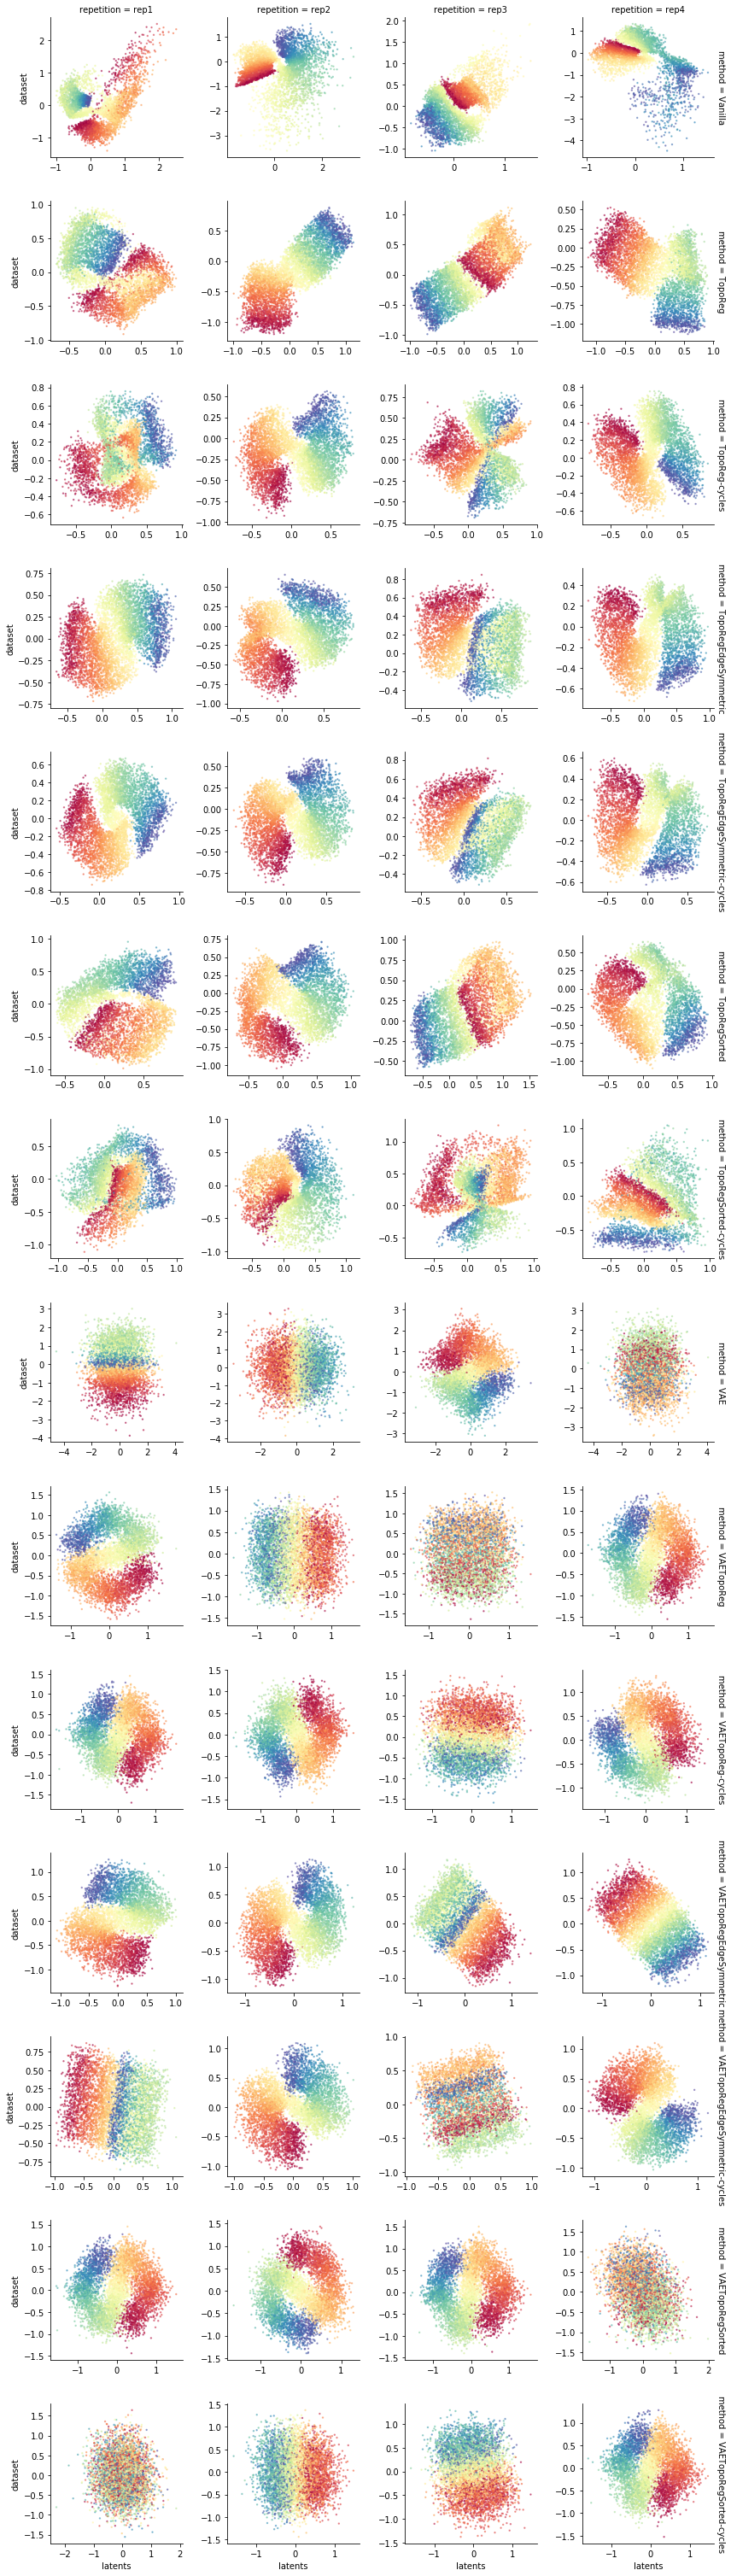

SwissRoll


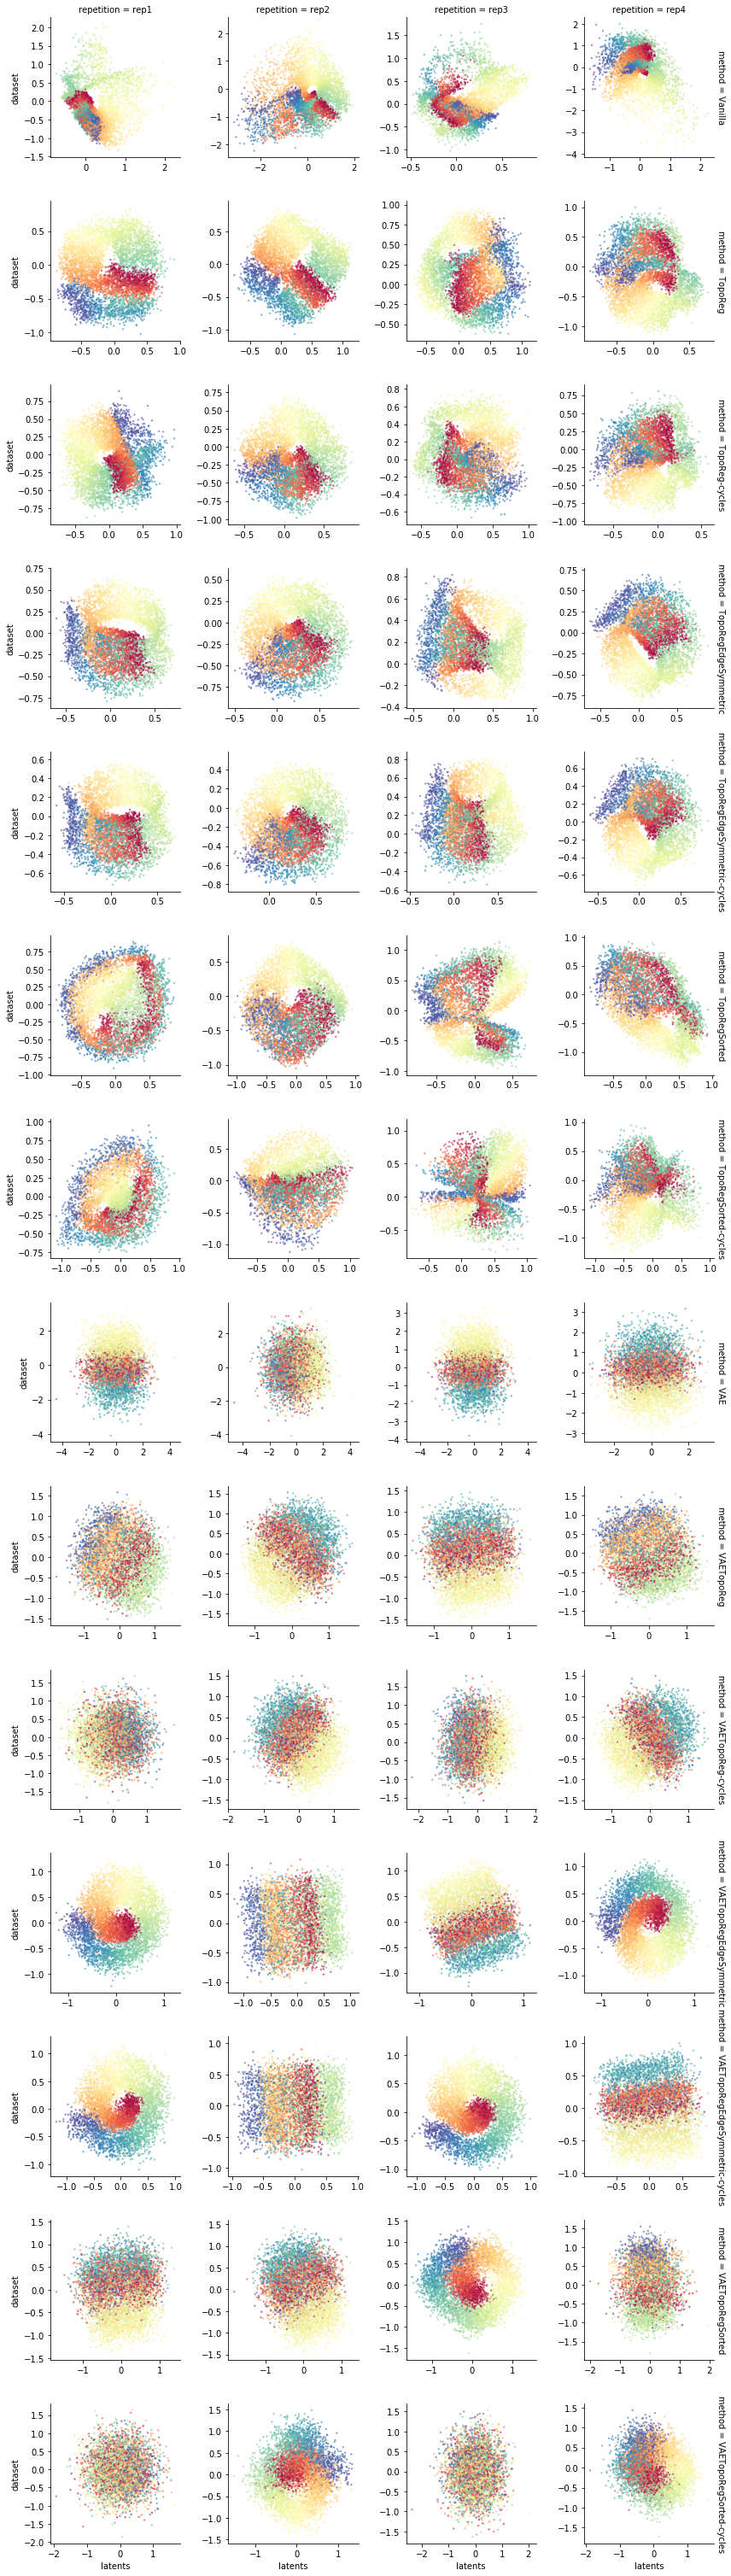

Spheres


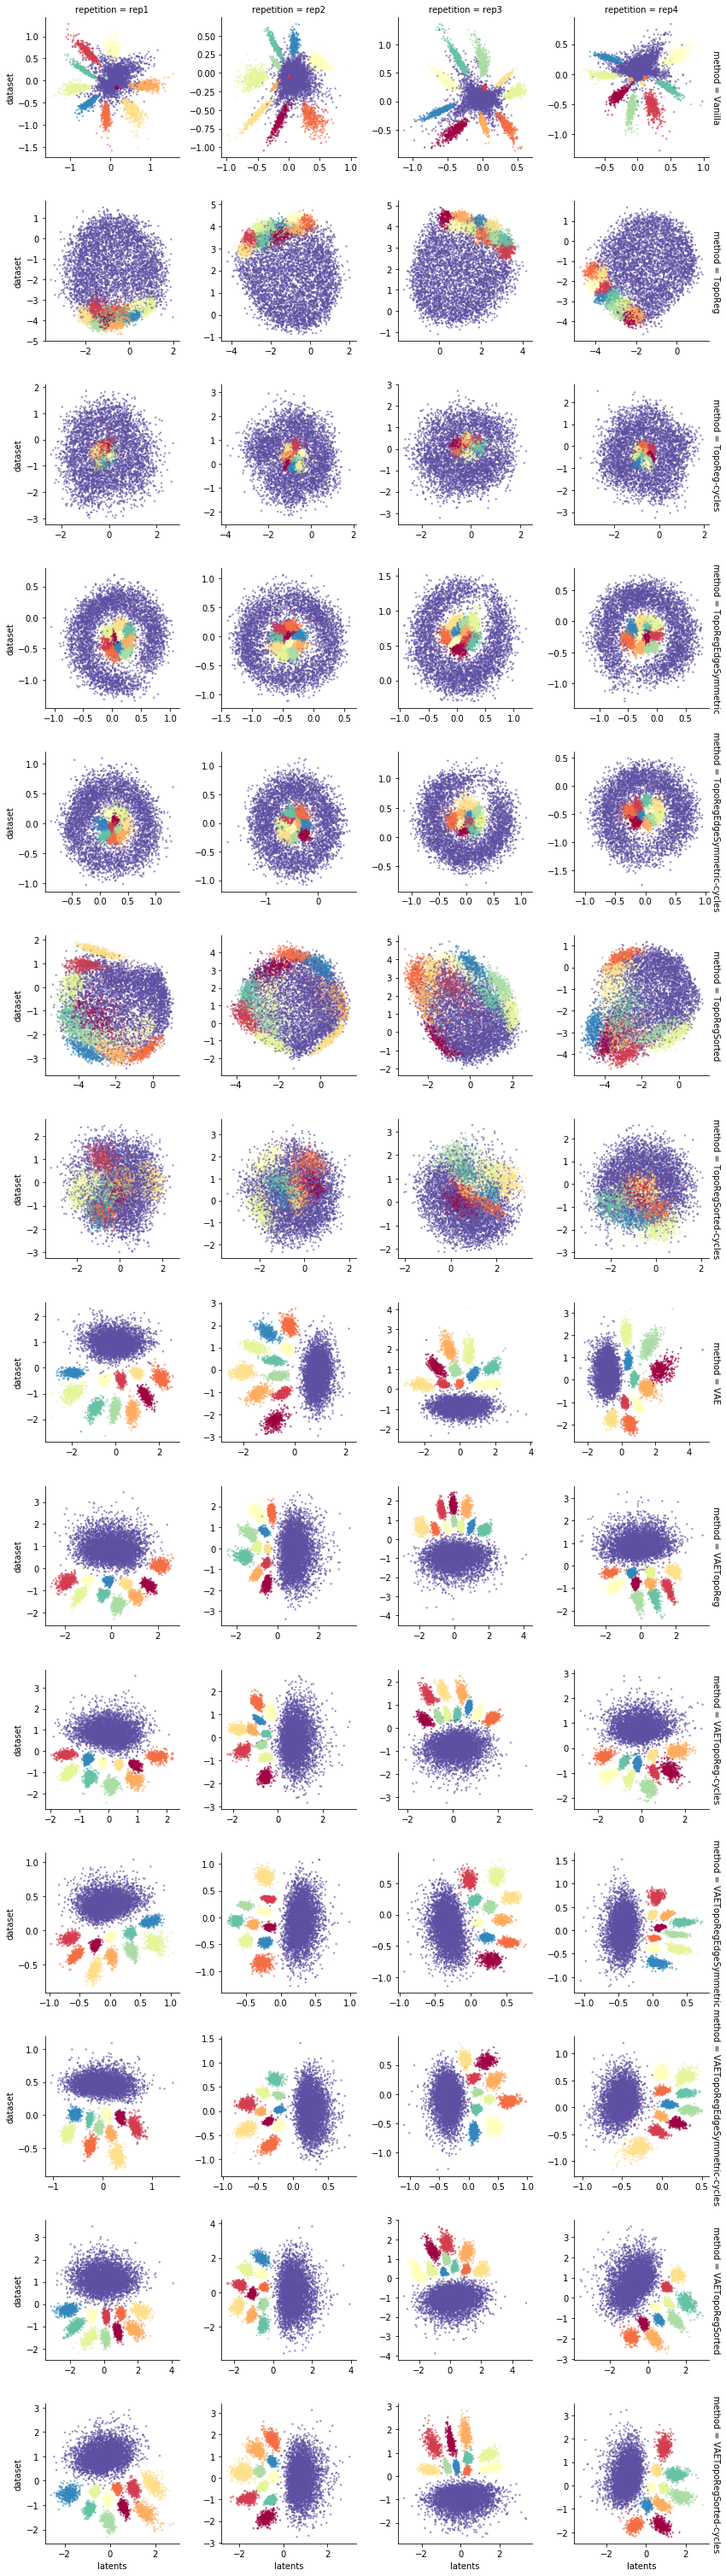

In [8]:
all_runs = all_runs.sort_values('method')
def plot_latent_space(transformed, dataset, **kwargs):
    transformed = transformed.iloc[0]
    all_labels = datasets[dataset.iloc[0]]['labels']
    plt.scatter(transformed[:, 0], transformed[:, 1], c=all_labels, cmap=plt.cm.Spectral, s=2., alpha=0.5)
for d in ['SCurve', 'SwissRoll', 'Spheres']:
    print(d)
    g = sns.FacetGrid(all_runs[all_runs['dataset'] == d], row='method', col='repetition', margin_titles=True,
                      sharex=False, sharey=False, col_order=['rep1', 'rep2', 'rep3', 'rep4'],
                      row_order=[
                          'Vanilla',
                          'TopoReg',
                          'TopoReg-cycles',
                          'TopoRegEdgeSymmetric',
                          'TopoRegEdgeSymmetric-cycles',
                          'TopoRegSorted',
                          'TopoRegSorted-cycles',
                          'VAE',
                          'VAETopoReg',
                          'VAETopoReg-cycles',
                          'VAETopoRegEdgeSymmetric',
                          'VAETopoRegEdgeSymmetric-cycles',
                          'VAETopoRegSorted',
                          'VAETopoRegSorted-cycles'
                      ])

    g.map(plot_latent_space, 'latents', 'dataset')
    plt.savefig(f'{d}_repetitions.png', pdi=200)
    plt.show()

Spheres


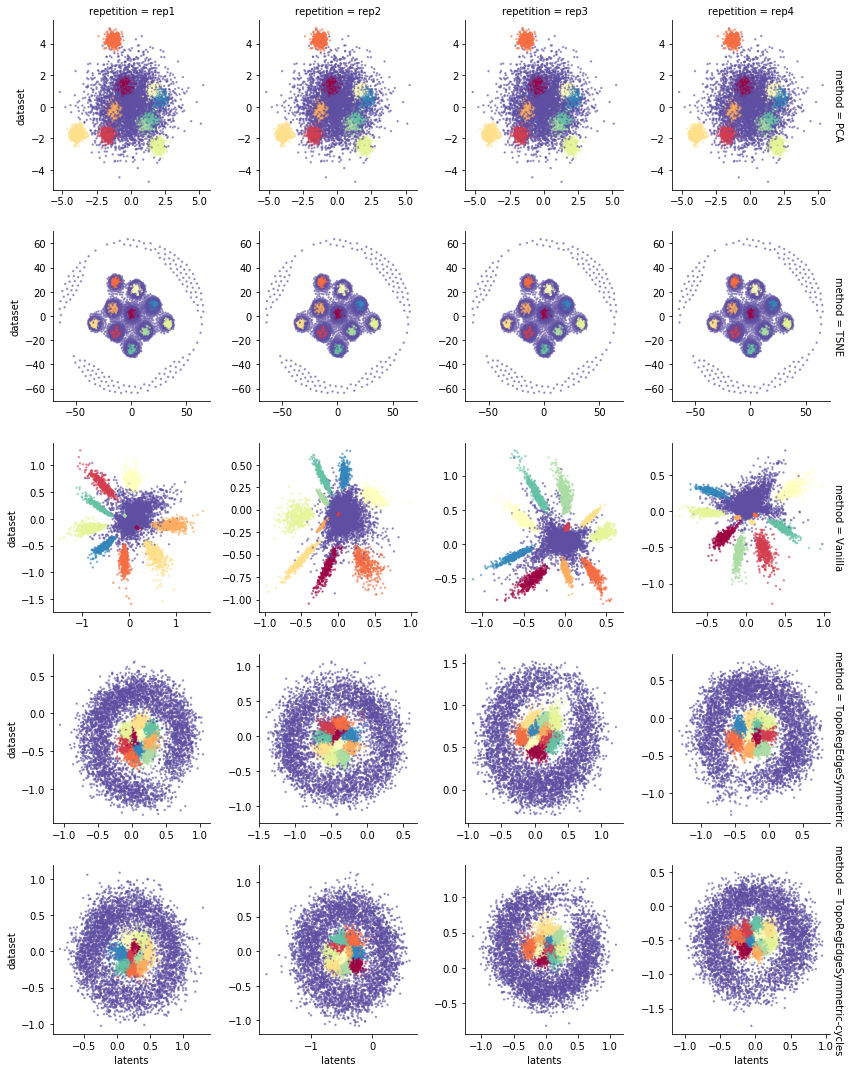

In [12]:
for d in ['Spheres']:
    print(d)
    g = sns.FacetGrid(all_runs[all_runs['dataset'] == d & all_runs['repetition'] == 'rep1'], row='method', col='repetition', margin_titles=True,
                      sharex=False, sharey=False, col_order=['rep1', 'rep2', 'rep3', 'rep4'],
                      row_order=[
                          'PCA',
                          'TSNE',
                          'Vanilla',
                          'TopoRegEdgeSymmetric',
                          'TopoRegEdgeSymmetric-cycles',
                      ])

    g.map(plot_latent_space, 'latents', 'dataset')
    plt.savefig(f'{d}_repetitions.png', pdi=200)
    plt.show()

In [ ]:
%matplotlib inline

dataset= 'dataset.SCurve' #'swissroll' #'scurve' #'spheres'
for dataset in experiments.keys():

    X = experiments[dataset]['data_space']
    labels = experiments[dataset]['model.Vanilla']['labels']

    methods = []
    all_Z = []
    for key, value in experiments[dataset].items():
        if key.startswith('model'):
            methods.append(key)
            all_Z.append(value['latent'])
    plott_all(dataset, X, labels, methods, all_Z)
    plt.show()
    plt.savefig(f'{dataset}.png', dpi=200)


#Z2 = experiments[dataset][methods[4]]['latent']


# plt.savefig(f'200_epochs_{dataset}_train.png')